<a href="https://colab.research.google.com/github/Devan5622/Devan5622/blob/main/Breast_Cancer_Image_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Image _Data/archive (2).zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
#Import the necessary libraries first

import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import cv2
     

In [ ]:
data = '/tmp'
No_breast_cancer = '/tmp/10253/0'
Yes_breast_cancer = '/tmp/10253/1'
     

In [ ]:
dirlist=[No_breast_cancer, Yes_breast_cancer]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  549    labels:  549


In [ ]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(549,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,/tmp/10253/0/10253_idx5_x2001_y1251_class0.png,No
1,/tmp/10253/0/10253_idx5_x1151_y1101_class0.png,No
2,/tmp/10253/0/10253_idx5_x1151_y1001_class0.png,No
3,/tmp/10253/0/10253_idx5_x1451_y1001_class0.png,No
4,/tmp/10253/0/10253_idx5_x1651_y1251_class0.png,No


In [ ]:
print(df['labels'].value_counts())

No     479
Yes     70
Name: labels, dtype: int64


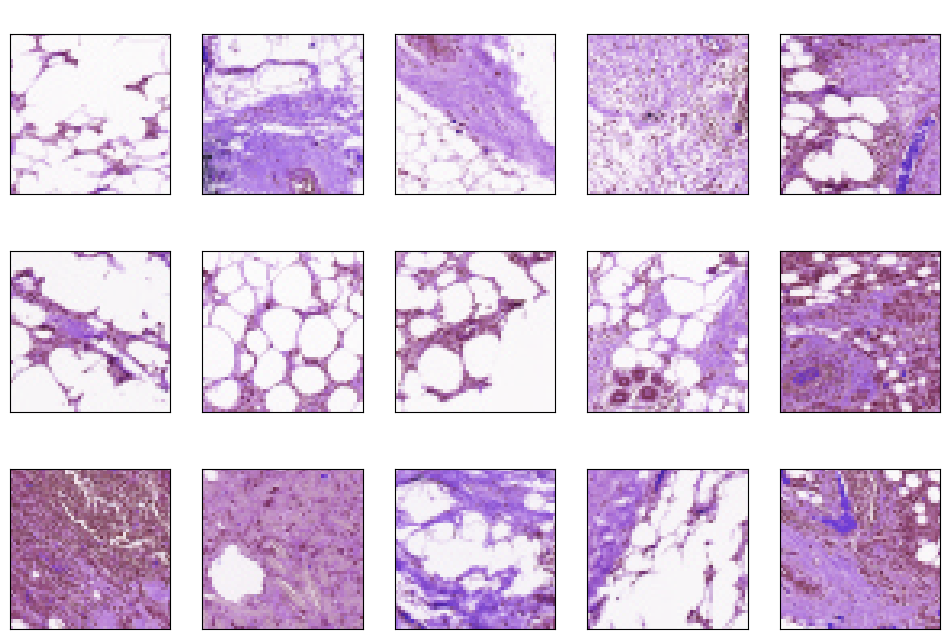

In [ ]:
#visualize brain tumor images

plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (468, 2)
test set shape: (28, 2)
validation set shape: (53, 2)


In [ ]:

train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [ ]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (224,224), batch_size = 32, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(224,224), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 468 validated image filenames belonging to 2 classes.
Found 53 validated image filenames belonging to 2 classes.
Found 28 validated image filenames belonging to 2 classes.


In [ ]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

**Transfer Learning**

In [ ]:
from tensorflow import keras
base_model = keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))


# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable

In [25]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)
]





model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 100, 
                    callbacks = [callbacks], verbose = 1)

Epoch 1/100
15/15 [==============================] - 99s 6s/step - loss: 0.6799 - accuracy: 0.5940 - val_loss: 0.6309 - val_accuracy: 0.6792
Epoch 2/100
15/15 [==============================] - 91s 6s/step - loss: 0.5751 - accuracy: 0.7244 - val_loss: 0.5901 - val_accuracy: 0.7358
Epoch 3/100
15/15 [==============================] - 91s 6s/step - loss: 0.4755 - accuracy: 0.8226 - val_loss: 0.5083 - val_accuracy: 0.8113
Epoch 4/100
15/15 [==============================] - 91s 6s/step - loss: 0.4522 - accuracy: 0.8419 - val_loss: 0.4834 - val_accuracy: 0.8679
Epoch 5/100
15/15 [==============================] - 94s 6s/step - loss: 0.4066 - accuracy: 0.8654 - val_loss: 0.4363 - val_accuracy: 0.8302
Epoch 6/100
15/15 [==============================] - 91s 6s/step - loss: 0.4236 - accuracy: 0.8675 - val_loss: 0.4537 - val_accuracy: 0.8491
Epoch 7/100
15/15 [==============================] - 92s 6s/step - loss: 0.4025 - accuracy: 0.8632 - val_loss: 0.4352 - val_accuracy: 0.8302
Epoch 8/100
1

In [26]:
model.save("model.h5")

** Evaluating the model**

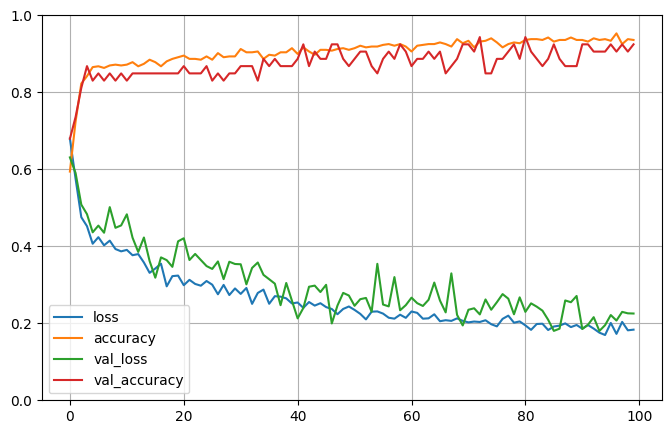

In [27]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()